In [226]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
from pandas.tools.plotting import scatter_matrix

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [194]:
# get train & test csv files as a DataFrame and then for simplicity of creating features put into a combined
# dataframe with an IsTrainData field indicating which is train / test data
titanic_df = pd.read_csv("../Data/train.csv", dtype={"Age": np.float64}, ).assign(IsTrainData = 1)
test_df    = pd.read_csv("../Data/test.csv", dtype={"Age": np.float64}, ).assign(IsTrainData = 0).assign(Survived = -999)
combined_df=pd.concat([titanic_df, test_df], ignore_index=True)

## Data Preperation ##

### Fares ###
Replace the one missing entry which we know was in the test set

In [195]:
# replace missing fare value with the mean. We do a quick check to get the Pclass and base the mean on that.
# print(combined_df[pd.isnull(combined_df.Fare)])
combined_df.loc[pd.isnull(combined_df.Fare), 'Fare'] = combined_df[combined_df.Pclass==3].Fare.mean()

### Embarked ###
One hot encode values

In [196]:
# Remove the 2 rows from the training set given these represent such a small % of the total data
combined_df = combined_df.dropna(subset=['Embarked'])

# one hot encode
ports = pd.get_dummies(combined_df['Embarked'], prefix='Embarked')
combined_df = pd.concat([combined_df, ports], axis = 1)
combined_df = combined_df.drop(["Embarked"],axis=1)

### Create Title Feature ###

In [197]:
def extract_title(x):
    # Get the person's title from their name combining less common or similar ones
    title = x.split(',')[1].split('.')[0][1:]
    if title in ['Mlle', 'Ms']:
        title = 'Miss'
    elif title == 'Mme':
        title = 'Mrs'
    elif title in ['Rev', 'Dr', 'Major', 'Col', 'Capt', 'Jonkheer', 'Dona']:
        title = 'Esteemed'
    elif title in ['Don', 'Lady', 'Sir', 'the Countess']:
        title = 'Royalty'
    return title

# Get the title, one hot encode and then remove both name and title.
combined_df = combined_df.assign(Title = lambda x: x.Name.map(extract_title))
titles = pd.get_dummies(combined_df['Title'], prefix='Title')
combined_df = pd.concat([combined_df, titles], axis = 1)

### Age ###

In [198]:
# Check the average
grouped = combined_df.groupby(['Sex','Pclass','Title'])
print(grouped['Age'].median())

def fillAges(row):
    if row['Sex']=='female' and row['Pclass'] == 1:
        if row['Title'] == 'Miss':
            return 30
        elif row['Title'] == 'Mrs':
            return 43
        elif row['Title'] == 'Esteemed':
            return 44
        elif row['Title'] == 'Royalty':
            return 41

    elif row['Sex']=='female' and row['Pclass'] == 2:
        if row['Title'] == 'Miss':
            return 21
        elif row['Title'] == 'Mrs':
            return 30

    elif row['Sex']=='female' and row['Pclass'] == 3:
        if row['Title'] == 'Miss':
            return 23
        elif row['Title'] == 'Mrs':
            return 28

    elif row['Sex']=='male' and row['Pclass'] == 1:
        if row['Title'] == 'Master':
            return 6
        elif row['Title'] == 'Mr':
            return 36
        elif row['Title'] == 'Esteemed':
            return 50
        elif row['Title'] == 'Royalty':
            return 45

    elif row['Sex']=='male' and row['Pclass'] == 2:
        if row['Title'] == 'Master':
            return 2
        elif row['Title'] == 'Mr':
            return 29
        elif row['Title'] == 'Esteemed':
            return 42

    elif row['Sex']=='male' and row['Pclass'] == 3:
        if row['Title'] == 'Master':
            return 7
        elif row['Title'] == 'Mr':
            return 28

#print(combined_df.apply(lambda r : fillAges(r) if np.isnan(r['Age']) else r['Age'], axis=1)[0:6])
#print(combined_df.head(6))
combined_df.Age = combined_df.apply(lambda r : fillAges(r) if np.isnan(r['Age']) else r['Age'], axis=1)

print(combined_df[combined_df['Age'].isnull()])

# convert from float to int
combined_df['Age'] = combined_df['Age'].astype(int)

Sex     Pclass  Title   
female  1       Esteemed    44.0
                Miss        30.0
                Mrs         45.0
                Royalty     40.5
        2       Miss        20.0
                Mrs         30.5
        3       Miss        18.0
                Mrs         31.0
male    1       Esteemed    51.0
                Master       6.0
                Mr          41.5
                Royalty     44.5
        2       Esteemed    41.5
                Master       2.0
                Mr          30.0
        3       Master       6.0
                Mr          26.0
Name: Age, dtype: float64
Empty DataFrame
Columns: [Age, Cabin, Fare, IsTrainData, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, Embarked_C, Embarked_Q, Embarked_S, Title, Title_Esteemed, Title_Master, Title_Miss, Title_Mr, Title_Mrs, Title_Royalty]
Index: []

[0 rows x 22 columns]


### Sex ###
Convert to numerical.

In [199]:
pd.unique(combined_df.Sex)

array(['male', 'female'], dtype=object)

In [200]:
# Convert string values to numerical one 
combined_df['Sex'] = combined_df['Sex'].map({'male':1,'female':0}).astype(int)

## Final correction of data ##

We need to remove some values such as string entries or others that we won't use. 

In [202]:
# drop string values - these should be convirted
combined_df.drop(["Cabin", "Ticket", "Name", "Title"],axis=1,inplace=True)
combined_df = combined_df.dropna()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1308
Data columns (total 18 columns):
Age               1307 non-null int32
Fare              1307 non-null float64
IsTrainData       1307 non-null int64
Parch             1307 non-null int64
PassengerId       1307 non-null int64
Pclass            1307 non-null int64
Sex               1307 non-null int32
SibSp             1307 non-null int64
Survived          1307 non-null int64
Embarked_C        1307 non-null float64
Embarked_Q        1307 non-null float64
Embarked_S        1307 non-null float64
Title_Esteemed    1307 non-null float64
Title_Master      1307 non-null float64
Title_Miss        1307 non-null float64
Title_Mr          1307 non-null float64
Title_Mrs         1307 non-null float64
Title_Royalty     1307 non-null float64
dtypes: float64(10), int32(2), int64(6)
memory usage: 183.8 KB


## Create Final Train and Test Datasets ##

In [203]:
# define training and testing sets
X_train = combined_df[combined_df['IsTrainData']==1].drop(["PassengerId", "Survived", "IsTrainData"],axis=1)
Y_train = combined_df[combined_df['IsTrainData']==1]["Survived"]
X_test  = combined_df[combined_df['IsTrainData']==0].drop(["PassengerId", "Survived", "IsTrainData"],axis=1)

# Verify totals
#print("Survived: " + str(len(Y_train[Y_train['Survived'] == 1])))
#print("Died: " + str(len(Y_train[Y_train['Survived'] == 0])))
print("Total Training Samples: " + str(len(X_train)))
print("Total Test Samples: " + str(len(X_test)))

Total Training Samples: 889
Total Test Samples: 418


## Build Models and Test ##
First some helper methods

In [229]:
# Run and evaluate model
def evaluate_model(model, X_train, Y_train, X_test):
    # fit the model against the training data
    model.fit(X_train, Y_train)

    # get scores based upon 5 fold cross validation
    scores = cross_validation.cross_val_score(model, X_train, Y_train, cv=5)
    print("Fold Accuracies: " + str(scores))
    print("Accuracy: %0.2f (+/- %0.2f @2std)" % (scores.mean(), scores.std() * 2))

    # Compute confusion matrix
    prediction = cross_validation.cross_val_predict(model, X_train, Y_train)
    cm = confusion_matrix(Y_train, prediction)
    print('Confusion matrix, without normalization')
    print(cm)
    plot_confusion_matrix(cm, np.array(["Died", "Survived"]))

    # predics test classes
    Y_pred = model.predict(X_test)
    return Y_pred


def get_optimised_model(model, hyperparameters, X_train, y_train, folds = 5):
    """
    Given a [model] and a set of possible [hyperparameters], along with 
    matricies corresponding to hold-out cross-validation, returns a model w/ 
    optimized hyperparameters, and prints out model evaluation metrics.
    """
    # fit the model against the training data and determine parameters to get an optimised model.
    optimized_model = GridSearchCV(model, hyperparameters, cv = folds, n_jobs = 1)
    optimized_model.fit(X_train, y_train)
    print("Best accuracy: %f using %s" % (optimized_model.best_score_, optimized_model.best_params_))
    #for params, mean_score, scores in optimized_model.grid_scores_:
    #    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))    

    # get scores based upon 5 fold cross validation
    scores = cross_validation.cross_val_score(optimized_model, X_train, Y_train, cv=5)
    print("Cross Validation Fold Accuracies: " + str(scores))
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f @2std)" % (scores.mean(), scores.std() * 2))

    # Compute confusion matrix
    #prediction = cross_validation.cross_val_predict(optimized_model, X_train, Y_train)
    #cm = confusion_matrix(Y_train, prediction)
    #print('Confusion matrix, without normalization')
    #print(cm)
    #plot_confusion_matrix(cm, np.array(["Died", "Survived"]))

    return optimized_model


def fit_model(model, X_train, Y_train):
    model.fit(X_train, Y_train)
    prediction = model.predict(X_train)
    print('Train Accuracy: ' + str(accuracy_score(Y_train, prediction)))
    cm = confusion_matrix(Y_train, prediction)
    print('Confusion matrix, without normalization')
    print(cm)
    plot_confusion_matrix(cm, np.array(["Died", "Survived"]))    

    
def get_test_predictions(model, X_test):
    
    # predics test classes
    Y_pred = model.predict(X_test)
    return Y_pred


def create_submission_file(test_df, Y_pred, file_name):
    submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
    submission.to_csv(file_name, index=False)

    
# Plot confusion matrix
def plot_confusion_matrix(cm, tickLabels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tickLabels))
    plt.xticks(tick_marks, tickLabels, rotation=45)
    plt.yticks(tick_marks, tickLabels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Baseline (ZeroR) classification ##

At this stage out training set has **889** entries of which the most common output class is that they died with **549** entries.

We could achieve an accuracy of **61.75%** by just predicting 'died' for all cases so this should be our absolute baseline! 

## Gender Based Model ##
Given the percentage of woman who survided was a lot higher than men, what happens if we just predict that all women lived and all men died

In [205]:
women = titanic_df[titanic_df['Sex']==0]
print('Number of females:', len(women))
men = titanic_df[titanic_df['Sex']==1]
print('Number of males:', len(men))

proportion_women_survived = np.sum(women['Survived'].tolist()) / np.size(women['Survived'].tolist()) 
proportion_men_survived = np.sum(men['Survived'].tolist()) / np.size(men['Survived'].tolist()) 

print('Proportion of women who survived is %s' % proportion_women_survived)
print('Proportion of men who survived is %s' % proportion_men_survived)

def predict(row):
    if row['Sex'] == 0:
        return 1
    else:
        return 0

gender_test_df = test_df
gender_test_df['Survived'] = gender_test_df.apply(predict, axis=1)

gender_submission = gender_test_df[['PassengerId', 'Survived']]
gender_submission.to_csv('gender_predictions.csv', index=False)

Number of females: 0
Number of males: 0
Proportion of women who survived is nan
Proportion of men who survived is nan


## Machine Learning Models ##

### Logistic Regression ###

Best accuracy: 0.829021 using {'C': 10, 'class_weight': None}
Fold Accuracies: [ 0.83146067  0.82022472  0.80337079  0.79213483  0.86440678]
Cross Validation Accuracy: 0.82 (+/- 0.05 @2std)
Train Accuracy: 0.834645669291
Confusion matrix, without normalization
[[487  62]
 [ 85 255]]
Wall time: 4.28 s


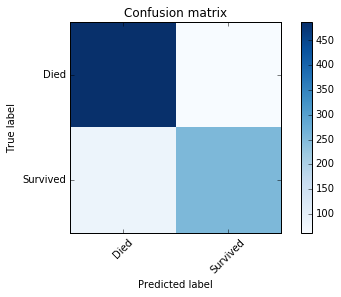

In [231]:
%%time

logreg_optimised = get_optimised_model(
    LogisticRegression(random_state = 25), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'class_weight': [None, 'balanced']}, 
    X_train, Y_train)
#logreg_optimised = LogisticRegression(random_state=25, C=10, class_weight=auto)

fit_model(logreg_optimised, X_train, Y_train)
Y_predLogisticRegression = get_test_predictions(logreg_optimised, X_test)

# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

create_submission_file(test_df, Y_predLogisticRegression, 'predictions_logreg.csv')

### Support Vector Machines ###

Best accuracy: 0.825647 using {'C': 1000, 'gamma': 0.0001}
Fold Accuracies: [ 0.81460674  0.8258427   0.82022472  0.79213483  0.86440678]
Cross Validation Accuracy: 0.82 (+/- 0.05 @2std)
Train Accuracy: 0.834645669291
Confusion matrix, without normalization
[[489  60]
 [ 87 253]]
Wall time: 2min 1s


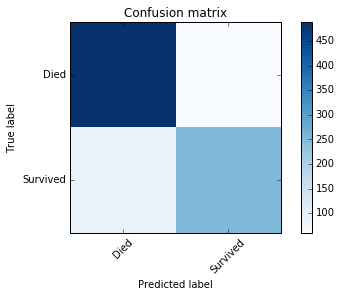

In [233]:
%%time

svc_optimised = get_optimised_model(
    SVC(random_state = 25), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': np.logspace(-9,3,13)}, 
    X_train, Y_train)
#svc_optimised = SVC(random_state=25, C=10, class_weight=auto)

fit_model(svc_optimised, X_train, Y_train)
Y_predSVC = get_test_predictions(svc_optimised, X_test)

create_submission_file(test_df, Y_predSVC, 'predictions_svc.csv')

### Random Forest ###

Best accuracy: 0.834646 using {'min_samples_leaf': 3, 'max_depth': None, 'min_samples_split': 1, 'n_estimators': 100}
Fold Accuracies: [ 0.82022472  0.78651685  0.86516854  0.80337079  0.85875706]
Cross Validation Accuracy: 0.83 (+/- 0.06 @2std)
Train Accuracy: 0.879640044994
Confusion matrix, without normalization
[[512  37]
 [ 70 270]]
Wall time: 27min 40s


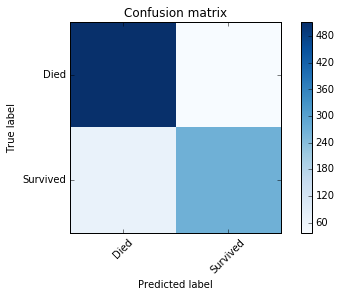

In [235]:
%%time

# Kaggle Score: 0.77512
# random_forest = RandomForestClassifier(criterion='entropy', n_estimators=50, max_depth=8, min_samples_split=8, max_features=5)
# Kaggle Score: 0.78469
#random_forest = RandomForestClassifier(criterion='entropy', n_estimators=150, max_depth=10, min_samples_split=8, max_features=10)
# Kaggle Score: 0.78947
#random_forest = RandomForestClassifier(criterion='gini', n_estimators=200, max_depth=10, min_samples_split=10, max_features=12)

rf_optimised = get_optimised_model(
    RandomForestClassifier(random_state = 25), {
        'n_estimators': [100, 200, 400, 800],
        'min_samples_split': [1, 3, 10],
        'min_samples_leaf': [1, 3, 10],
        'max_depth': [3, None]}, 
    X_train, Y_train)
#r_optimised = RandomForestClassifier(n_estimators=100, min_samples_split=1, min_samples_leaf=3, max_depth=None)
#r_optimised = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=10, min_samples_split=10, max_features=12)

fit_model(rf_optimised, X_train, Y_train)
Y_predRF = get_test_predictions(rf_optimised, X_test)

create_submission_file(test_df, Y_predRF, 'predictions_rf.csv')


#Best: 0.814398 using {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'gini', 'n_estimators': 50, 'max_features': 2}
#Best: 0.843645 using {'criterion': 'entropy', 'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 5}
#Best: 0.851519 using {'max_features': 12, 'max_depth': 10, 'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 200}

### K Nearest Neighbors ###

Best accuracy: 0.717660 using {'n_neighbors': 3}
Fold Accuracies: [ 0.60674157  0.69101124  0.69662921  0.73595506  0.72316384]
Cross Validation Accuracy: 0.69 (+/- 0.09 @2std)
Train Accuracy: 0.832395950506
Confusion matrix, without normalization
[[488  61]
 [ 88 252]]
Wall time: 3.09 s


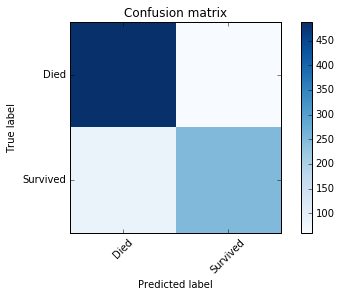

In [237]:
%%time

knn_optimised = get_optimised_model(
    KNeighborsClassifier(), {
        'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}, 
    X_train, Y_train)
#knn_optimised = KNeighborsClassifier(n_neighbors = 3)

fit_model(knn_optimised, X_train, Y_train)
Y_predKNN = get_test_predictions(knn_optimised, X_test)

create_submission_file(test_df, Y_predKNN, 'predictions_knn.csv')

Fold Accuracies: [ 0.76966292  0.81460674  0.79775281  0.76404494  0.85310734]
Accuracy: 0.80 (+/- 0.06 @2std)
Confusion matrix, without normalization
[[468  81]
 [104 236]]


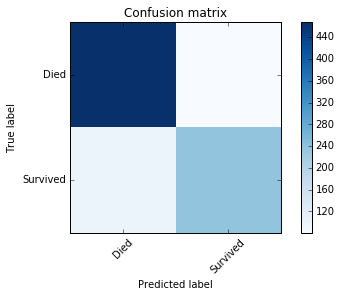

In [210]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
Y_predGaussian = evaluate_model(gaussian, X_train, Y_train, X_test)

### Gradient Boosted Trees ###

In [ ]:
%%time

gbt_optimised = get_optimised_model(
    xgb.XGBClassifier(learning_rate = 0.05, n_estimators = 200, seed = 25), {
        'max_depth': range(3, 10, 2), 
        'min_child_weight': range(1, 6, 2),
        'gamma': [i / 10.0 for i in range(0, 5)], 
        'reg_alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
    X_train, Y_train)
#gbt_optimised = KNeighborsClassifier(n_neighbors = 3)

fit_model(gbt_optimised, X_train, Y_train)
Y_pred_gbt = get_test_predictions(gbt_optimised, X_test)

create_submission_file(test_df, Y_pred_gbt, 'predictions_gbt.csv')

### Neural Network ###

In [50]:
# Neural Network

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(40, input_dim=15, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(y=Y_train.as_matrix() , n_folds=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train.as_matrix() , Y_train.as_matrix() , cv=kfold)

print("Accuracy: %.2f%% (%.2f%% @2std)" % (results.mean()*100, results.std()*100))

Accuracy: 82.34% (3.42% @2std)


## Create Majority Vote Ensemble ##

In [255]:
# Creates a submission from a majority voting ensemble, given keys, and a list of
# predictions and votes.
def majority_vote_ensemble(keys, predictions_votes, name='ensemble_majority_vote.csv':
    
    results = []
    for predictions, votes in predictions_votes:
        predictions[predictions == 0] = -1
        results.append((predictions, votes))
    
    # Create the ensemble
    ensemble = keys.to_frame().assign(Survived = 0)
    for probs, votes in results:
        for i in range(0, votes):
            ensemble = ensemble.assign(Survived = lambda x: x.Survived + probs)
    combined_result = ensemble.assign(Survived = lambda x: np.where(x.Survived > 0, 1, 0))
    combined_result.to_csv(name, index = False)
    return None
       
predictions_votes = [
    (Y_predLogisticRegression, 1),
    (Y_predSVC, 1),
    (Y_predRF, 1),
    (Y_predKNN, 1)
]

majority_vote_ensemble(test_df['PassengerId'], predictions_weights)

In [259]:
# Creates a submission from a weighted average of probabilities ensemble, 
# given training/testing data and a list of models and weights
def weighted_average_ensemble(keys, predictions_weights, name='ensemble_weighted_average.csv'):
    weights_sum = sum([w[1] for w in predictions_weights])    
    results = []
    for predictions, weight in predictions_weights:
        predictions[predictions == 0] = -1
        results.append((predictions, weight))
    
    # Create the ensemble
    ensemble = keys.to_frame().assign(Survived = 0)
    for probs, weights in results:
        for i in range(0, votes):
            ensemble = ensemble.assign(Survived = lambda x: x.Survived + probs * weight)
    combined_result = ensemble.assign(Survived = lambda x: x.Survived / weights_sum)
    combined_result = combined_result.assign(Survived = lambda x: np.where(x.Survived >= 0.5, 1, 0))
    combined_result.to_csv(name, index = False)
    return None
       
models_weights = [
    (Y_predLogisticRegression, 1),
    (Y_predSVC, 1),
    (Y_predRF, 1),
    (Y_predKNN, 1)
]

weighted_average_ensemble(test_df['PassengerId'], predictions_weights)

NameError: name 'votes' is not defined

In [ ]:
# Weighted average, give the logistic regression more say
models_weights = [
    (rf_model.best_estimator_, 1),
    (lr_model.best_estimator_, 2),
    (svm_model.best_estimator_, 1),
    (gbt_model.best_estimator_, 1)
]

weighted_average_ensemble('submissions/ensemble_weighted_avg.csv', 
                          models_weights, train, outcomes, to_predict)